<a href="https://colab.research.google.com/github/adityaRajPratapSingh/Named-Entity-Recognition-NER-and-Feature-Engineering-for-Real-and-Fake-Tweets/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# downloads and imports

In [ ]:
!git clone https://github.com/KaiDMML/FakeNewsNet.git
!pip install spacy
!python3 -m spacy download en_core_web_sm
!pip install lxml

Cloning into 'FakeNewsNet'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 759 (delta 12), reused 8 (delta 3), pack-reused 735 (from 1)
Receiving objects: 100% (759/759), 43.99 MiB | 29.25 MiB/s, done.
Resolving deltas: 100% (156/156), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import json
import logging
import time

import requests
from tqdm.notebook import tqdm
import concurrent.futures
from bs4 import BeautifulSoup
from tqdm.asyncio import tqdm
!pip install aiohttp
import aiohttp
import asyncio
!pip install newspaper3k
!pip show newspaper3k
!pip install lxml[html_clean]
import sys
sys.path.append('/root/.local/lib/python3.10/site-packages')
from newspaper import Article

!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 11.8 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=95b8465ac4273b86cb07dac9be5503b1747a6d1f03aa8376d5803fb8a2176eea
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=40a925657b1df8d119111f3008e5ecc306f636438e4f446847e643c245e82f25
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc93

In [ ]:
nlp_model_from_spacy = spacy.load('en_core_web_sm')

In [ ]:
def preprocess_1_adding_popularity(org_df:pd.DataFrame)->pd.DataFrame:
  df = org_df.copy()
  popularity = []
  for i in df['tweet_ids']:
    if pd.isna(i):
      popularity.append(0)
    else:
      popularity.append(len(i.split('\t')))
  df['popularity'] = popularity
  return df

def basic_cleaning(text:str)->str:
  text = text.lower()
  text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
  return text

def preprocess_2_adding_ner(org_df:pd.DataFrame)->pd.DataFrame:
  df = org_df.copy()

  PERSON,ORG,GPE,EVENT,PRODUCT,TIME,MONEY,QUANTITY = [],[],[],[],[],[],[],[]
  NORP,LANG,FAC,DATE,PERCENT,ORDINAL,CARDINAL=[],[],[],[],[],[],[]

  for i in df['article']:
    PERSON_C,ORG_C,GPE_C,EVENT_C,PRODUCT_C,TIME_C,MONEY_C,QUANTITY_C,NORP_C,LANG_C=0,0,0,0,0,0,0,0,0,0
    FAC_C,DATE_C,PERCENT_C,ORDINAL_C,CARDINAL_C=0,0,0,0,0

    if pd.isna(i):
      PERSON.append(0)
      ORG.append(0)
      GPE.append(0)
      EVENT.append(0)
      PRODUCT.append(0)
      TIME.append(0)
      MONEY.append(0)
      QUANTITY.append(0)
      NORP.append(0)
      LANG.append(0)
      FAC.append(0)
      DATE.append(0)
      PERCENT.append(0)
      ORDINAL.append(0)
      CARDINAL.append(0)
    else:

      res = nlp_model_from_spacy(i)
      for ent in res.ents:
        if ent.label_ == 'PERSON':
            PERSON_C += 1
        if ent.label_ == 'ORG':
            ORG_C += 1
        if ent.label_ == 'GPE':
            GPE_C += 1
        if ent.label_ == 'EVENT':
            EVENT_C += 1
        if ent.label_ == 'PRODUCT':
            PRODUCT_C += 1
        if ent.label_ == 'TIME':
            TIME_C += 1
        if ent.label_ == 'MONEY':
            MONEY_C += 1
        if ent.label_ == 'QUANTITY':
            QUANTITY_C += 1
        if ent.label_ == 'NORP':
          NORP_C+=1
        if ent.label_ == "LANGUAGE":
          LANG_C+=1
        if ent.label_ == "FAC":
          FAC_C+=1
        if ent.label_ == "DATE":
          DATE_C+=1
        if ent.label_ == 'PERCENT':
          PERCENT_C+=1
        if ent.label_ == 'ORDINAL':
          ORDINAL_C+=1
        if ent.label_ == 'CARDINAL':
          CARDINAL_C+=1
      PERSON.append(PERSON_C)
      ORG.append(ORG_C)
      GPE.append(GPE_C)
      EVENT.append(EVENT_C)
      PRODUCT.append(PRODUCT_C)
      TIME.append(TIME_C)
      MONEY.append(MONEY_C)
      QUANTITY.append(QUANTITY_C)
      NORP.append(NORP_C)
      LANG.append(LANG_C)
      FAC.append(FAC_C)
      DATE.append(DATE_C)
      PERCENT.append(PERCENT_C)
      ORDINAL.append(ORDINAL_C)
      CARDINAL.append(CARDINAL_C)

  df['person']=PERSON
  df['org']=ORG
  df['gpe']=GPE
  df['event']=EVENT
  df['product']=PRODUCT
  df['time']=TIME
  df['money']=MONEY
  df['quantity']=QUANTITY
  df['norp'] = NORP
  df['lang'] = LANG
  df['fac']=FAC
  df['date'] = DATE
  df['percent']= PERCENT
  df['ordinal'] = ORDINAL
  df['cardinal']=CARDINAL

  return df


def add_reality_real(org_df:pd.DataFrame)->pd.DataFrame:
  df= org_df.copy()
  reality = [1]*len(df['title'])
  df['reality'] = reality
  return df

def add_reality_fake(org_df:pd.DataFrame)->pd.DataFrame:
  df= org_df.copy()
  reality = [0]*len(df['title'])
  df['reality'] = reality
  return df


def combine_df(li:list[pd.DataFrame])->pd.DataFrame:
  combined_df = pd.concat(li, ignore_index=True)
  return combined_df

def complete_pp_and_merge(real:list[pd.DataFrame], fake:list[pd.DataFrame])->pd.DataFrame:
  dfs=[]
  for i in real:
    i = preprocess_1_adding_popularity(i)
    i = preprocess_2_adding_ner(i)
    i = add_reality_real(i)
    dfs.append(i)
  for i in fake:
    i = preprocess_1_adding_popularity(i)
    i = preprocess_2_adding_ner(i)
    i = add_reality_fake(i)
    dfs.append(i)
  c = combine_df(dfs)
  return c

def fetch_article_newspaper(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        if len(article.text) > 100:
            return basic_cleaning(article.text)
        return None
    except Exception as e:
        return None

async def fetch_article(session, url):
    return await asyncio.to_thread(fetch_article_newspaper, url)

async def process_urls(urls):
    articles = []
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_article(session, url) for url in urls]
        for f in tqdm(asyncio.as_completed(tasks), total=len(urls)):
            result = await f
            articles.append(result)
    return articles

def add_article_async(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    urls = df['news_url'].tolist()
    articles = asyncio.run(process_urls(urls))
    df['article'] = articles
    return df

In [ ]:
df_r_1=pd.read_csv('/content/FakeNewsNet/dataset/gossipcop_real.csv')
df_r_2=pd.read_csv('/content/FakeNewsNet/dataset/politifact_real.csv')
df_f_1=pd.read_csv('/content/FakeNewsNet/dataset/gossipcop_fake.csv')
df_f_2=pd.read_csv('/content/FakeNewsNet/dataset/politifact_fake.csv')

In [ ]:
test_urls = df_r_1['news_url'].head(2).tolist()
articles = asyncio.run(process_urls(test_urls))
print(articles)

100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

['kate middleton says she and prince william are focusing on simply loving and being loved as her cancer journey reaches a turning point', 'kylie jenner reportedly doesnt want to talk about her love life on her new reality show life of kylie which will debut in august\n\nthe 19yearold reality icon has refused to discuss her ex tyga who has a son with blac chyna or her new beau travis scott according to a report from life  style\n\nthe keeping up with the kardashians star only wants her spinoff to be about her businesses and her social media presence it was claimed\n\nschtum kylie jenner is reportedly refusing to discuss dating life for her new show life of kylie\n\nnetwork executives are now panicking after test audiences found the show too boring\n\nwhen the show was announced in april the network had agreed to follow kylies life meaning her personal life as well and insider claimed\n\nbut when it came time to shoot kylie only wanted to document her business and her life on social med

In [ ]:
df_r_1_art = add_article_async(df_r_1)
df_r_2_art = add_article_async(df_r_2)
df_f_1_art = add_article_async(df_f_1)
df_f_2_art = add_article_async(df_f_2)

data_full = complete_pp_and_merge(
    real = [df_r_1_art, df_r_2_art],
    fake = [df_f_1_art, df_f_2_art]
)

  1%|▏         | 230/16817 [01:08<1:09:24,  3.98it/s]/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
 28%|██▊       | 122/432 [00:06<00:15, 19.86it/s]WARNING:newspaper.parsers:fromstring() returned an invalid string: 

...
100%|██████████| 432/432 [00:26<00:00, 16.60it/s]


,id,news_url,title,tweet_ids,article,popularity,person,org,gpe,event,...,money,quantity,norp,lang,fac,date,percent,ordinal,cardinal,reality
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,None,67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,None,51,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,None,48,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,None,53,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,None,291,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23191,politifact14944,http://thehill.com/homenews/senate/369928-who-...,Who is affected by the government shutdown?,954602090462146560\t954602093171609600\t954650...,None,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23192,politifact14071,https://web.archive.org/web/20170322070001/htt...,Lindsey Graham Threatens To Convert To Democra...,740351669834244096\t740391312277573632\t740474...,early voting began in north carolina in octobe...,238,0,1,2,0,...,0,0,0,0,0,6,0,0,2,0
23193,politifact13577,http://archive.is/DQqCx,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,810939651900907520\t814738996706164737\t814917...,None,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23194,politifact13560,politicono.com/palin-calls-boycott-mall-americ...,Sarah Palin Calls To Boycott Mall Of America B...,805216591424212993\t805222830023540736\t805223...,a slot is a thin opening groove notch or slit ...,84,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,title,article,popularity,person,org,gpe,event,product,time,money,quantity,norp,lang,fac,date,percent,ordinal,cardinal,reality
0,gossipcop-882573,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,None,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,gossipcop-875924,Kylie Jenner refusing to discuss Tyga on Life ...,None,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,gossipcop-894416,Quinn Perkins,None,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,gossipcop-857248,I Tried Kim Kardashian's Butt Workout & Am For...,None,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,gossipcop-884684,Celine Dion donates concert proceeds to Vegas ...,None,291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23191,politifact14944,Who is affected by the government shutdown?,None,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23192,politifact14071,Lindsey Graham Threatens To Convert To Democra...,early voting began in north carolina in octobe...,238,0,1,2,0,0,0,0,0,0,0,0,6,0,0,2,0
23193,politifact13577,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,None,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23194,politifact13560,Sarah Palin Calls To Boycott Mall Of America B...,a slot is a thin opening groove notch or slit ...,84,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
from google.colab import files
data_full.to_csv('data_full.csv', index=False)
files.download('data_full.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_full = pd.read_csv('/content/data_full.csv')

In [ ]:
data_features = data_full.drop(columns=['news_url', 'tweet_ids'], inplace=False)
data_features = data_features.dropna(subset=['article'], inplace=False)

display(data_features)

,id,title,article,popularity,person,org,gpe,event,product,time,money,quantity,norp,lang,fac,date,percent,ordinal,cardinal,reality
6,gossipcop-848092,Handmaid's Tale Renewed for Season 3,the day has finally come to learn the truth ab...,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
8,gossipcop-926957,When Will ‘Claws’ Season 2 Be On Hulu?,nine months after michael buble and luisana lo...,10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0
9,gossipcop-930832,Critics' Choice Awards - Critics' Choice Awards,miley cyrus and liam hemsworth spent their dat...,2.0,9.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,1.0
10,gossipcop-918456,"Bellamy Young Opens Up About Being Adopted, He...",in case you missed it the romance between just...,12.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
11,gossipcop-912950,Find Out Which of The Real Housewives of Orang...,parentshaming is a mainstay of social media an...,32.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,politifact14731,Flake: “Religious tests should have no place i...,with the fire of a baptist preacher georgias n...,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,12.0,2.0,0.0,11.0,1.0
17437,politifact329,Change We Can Believe In,following is a transcript of the first preside...,182.0,116.0,68.0,265.0,1.0,0.0,26.0,23.0,1.0,73.0,0.0,1.0,81.0,12.0,21.0,97.0,1.0
17438,politifact1576,deputy director of national health statistics ...,political figures c p 2 chris christie wesley...,0.0,41.0,25.0,16.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0,0.0,116.0,0.0,1.0,140.0,1.0
17439,politifact4720,Romneys ProLife Conversion Myth or Reality Jun...,for release 1000 am et tuesday october 29 2024...,1.0,2.0,7.0,2.0,0.0,4.0,12.0,7.0,4.0,1.0,0.0,1.0,582.0,7.0,2.0,2098.0,1.0


min values:
id                                             gossipcop-541230
title         "13 Reasons Why" premiere party canceled after...
article       \n\n\n\n\n\n\n\nbillboard music awards is a br...
popularity                                                  0.0
person                                                      0.0
org                                                         0.0
gpe                                                         0.0
event                                                       0.0
product                                                     0.0
time                                                        0.0
money                                                       0.0
quantity                                                    0.0
norp                                                        0.0
lang                                                        0.0
fac                                                         0.0
date                        

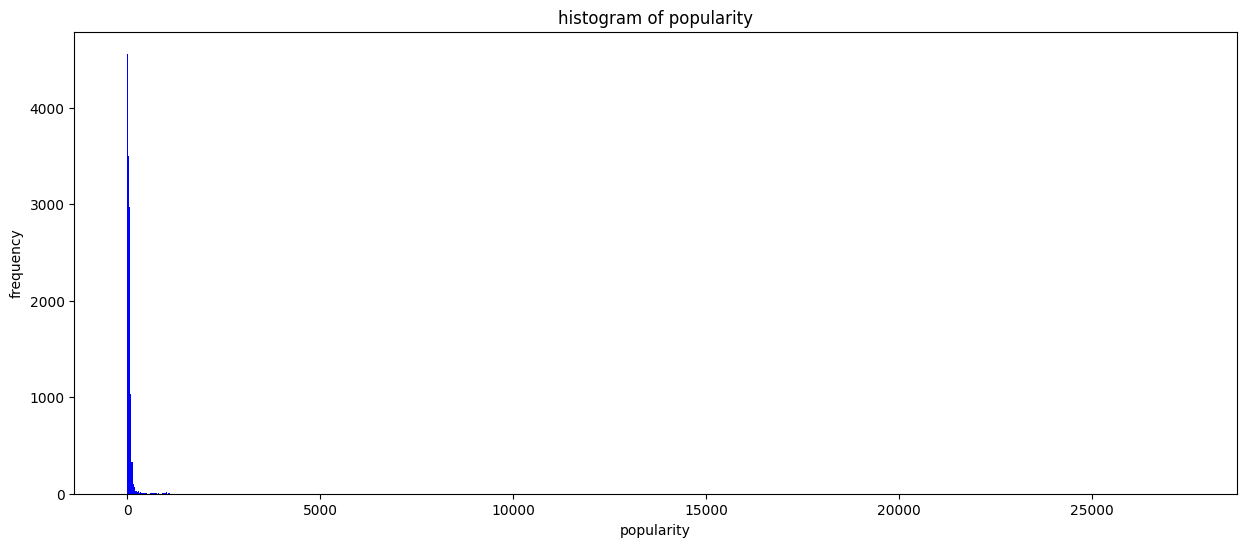

In [ ]:
min_vals = data_features.min()
max_vals = data_features.max()

print(f"min values:\n{min_vals}\n\n\nmax values:\n{max_vals}")

plt.figure(figsize=(15, 6))
plt.hist(data_features['popularity'], bins=1000, color='blue')
plt.title('histogram of popularity')
plt.xlabel("popularity")
plt.ylabel('frequency')
plt.show()

min values:
id                                             gossipcop-541230
title         "13 Reasons Why" premiere party canceled after...
article       \n\n\n\n\n\n\n\nbillboard music awards is a br...
popularity                                                  0.0
person                                                      0.0
org                                                         0.0
gpe                                                         0.0
event                                                       0.0
product                                                     0.0
time                                                        0.0
money                                                       0.0
quantity                                                    0.0
norp                                                        0.0
lang                                                        0.0
fac                                                         0.0
date                        

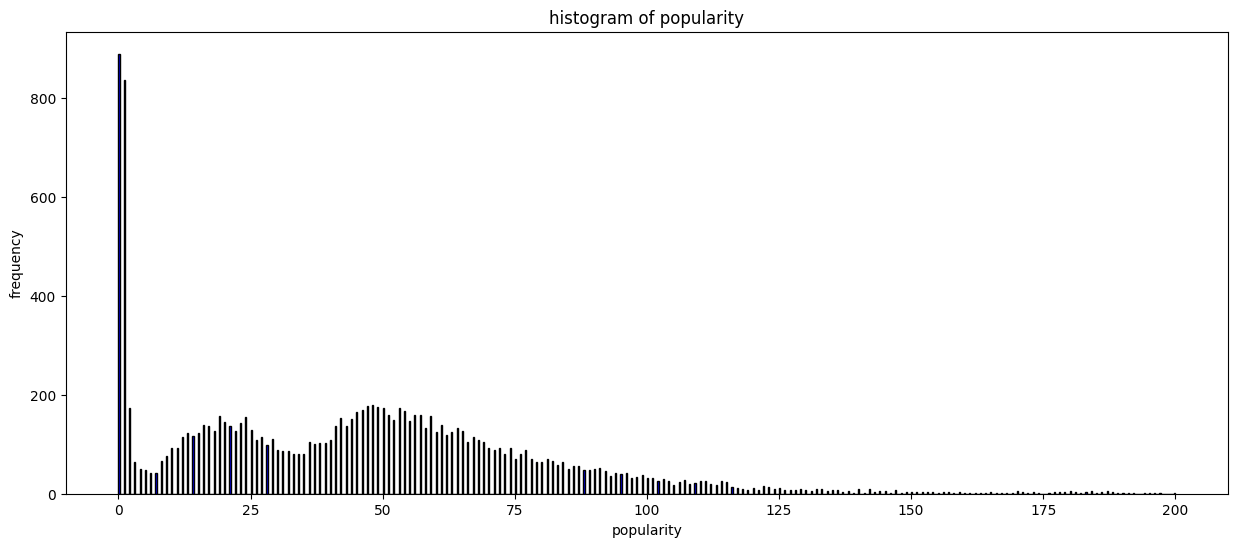

In [ ]:
filtered_data_features  = data_features[data_features['popularity'] <= 200]

min_vals = filtered_data_features.min()
max_vals = filtered_data_features.max()

print(f"min values:\n{min_vals}\n\n\nmax values:\n{max_vals}")

plt.figure(figsize=(15, 6))
plt.hist(filtered_data_features['popularity'], bins=1000, color='blue', edgecolor='black')
plt.title('histogram of popularity')
plt.xlabel("popularity")
plt.ylabel('frequency')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

NUM_WORDS=10000
OOV = '<OOV>'
MAX_LEN = 100

In [ ]:
filtered_data_features.loc[:, 'popularity'] = filtered_data_features['popularity'] / filtered_data_features['popularity'].max()
x = filtered_data_features['article']
y = filtered_data_features['popularity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)
x_train_padded = pad_sequences(x_train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
mod_6 = Sequential([
    Embedding(len(tokenizer.word_index)+1, 128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

mod_6.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(mode='min', monitor='loss', patience=10)
his_6 = mod_6.fit(
    x_train_padded, y_train,
    epochs=50,
    batch_size=64,
    callbacks = [early_stopping]
)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.0652 - loss: 0.0351 - mae: 0.1453
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0722 - loss: 0.0276 - mae: 0.1307
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0704 - loss: 0.0187 - mae: 0.1028
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0704 - loss: 0.0110 - mae: 0.0772
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0738 - loss: 0.0081 - mae: 0.0648
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0666 - loss: 0.0064 - mae: 0.0551
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0721 - loss: 0.0055 - mae: 0.0500
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0661 - loss: 0.0055 - mae: 0.0475
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0690 - loss: 0.0050 - mae: 0.0449
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0691 - loss: 0.0048 - m

In [ ]:
loss, mae = model.evaluate(x_test_padded, y_test)
print(f"Mean Absolute Error on Test Data: {mae}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0378 - mae: 0.1542
Mean Absolute Error on Test Data: 0.1515747755765915


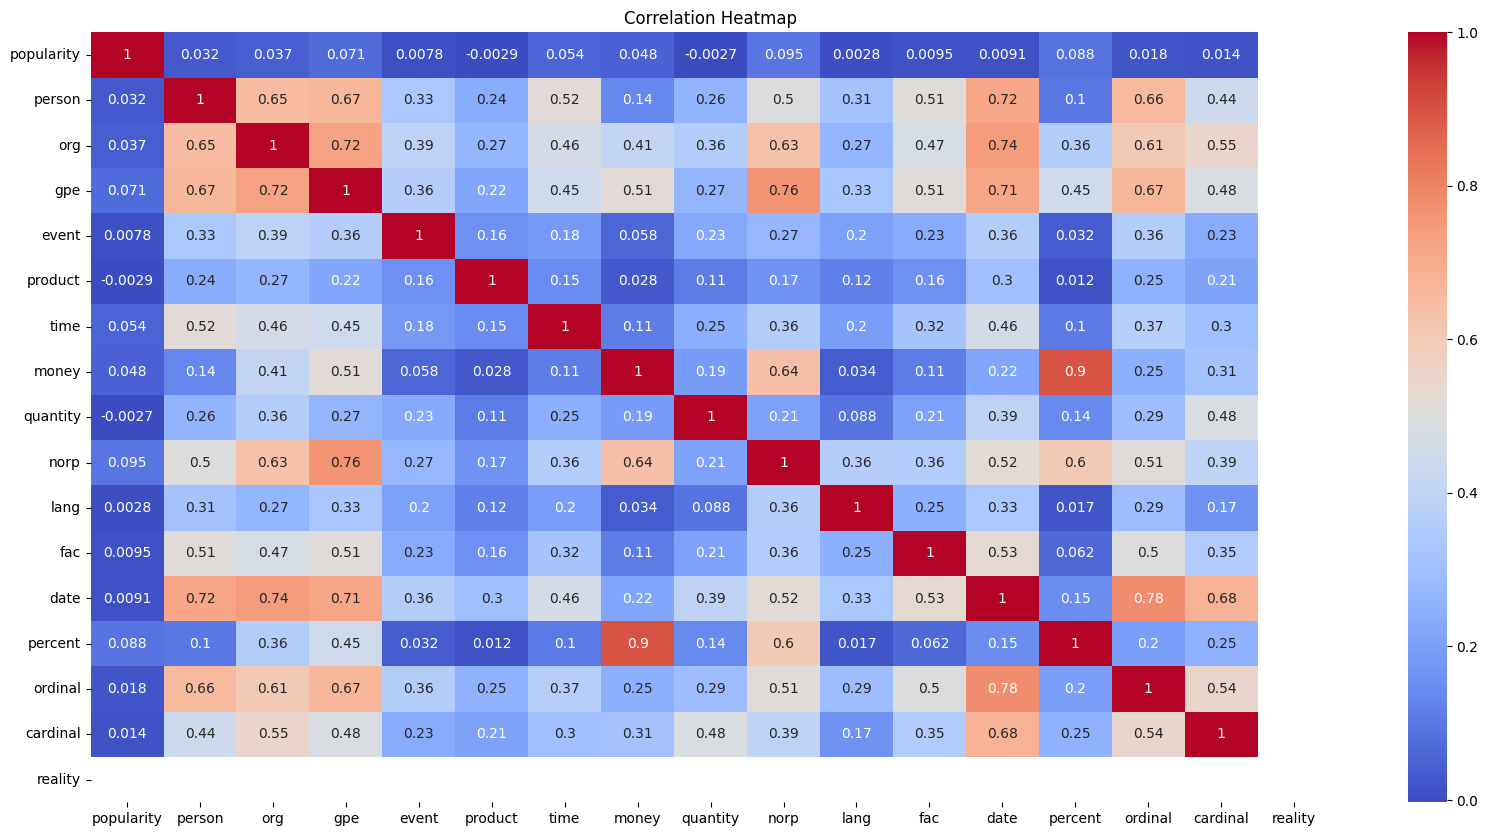

In [ ]:
import seaborn as sns

columns_to_analyze = data_features.loc[:, 'popularity':].columns
subset_corr = data_features[columns_to_analyze].corr()


plt.figure(figsize=(20, 10))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()